# Projekt IUM – 2023L

##### Temat 8. - “Nasza baza utworów jest całkiem bogata – opisywane są one wieloma ciekawymi parametrami. Dlaczego jednak do tej pory nikt nie oznaczył czy są w skali dur czy mol? Musimy zmienić tę sytuację!”

### Autorzy:
 - Gabriela Topczewska
 - Karol Rogoziński

## Etap 2. - Przygotowanie modeli

### Podstawowy model

Jako podstawowy model wykorzystamy baseline, który posłużył jako punkt odniesienia podczas wyznaczania z Klientem kryterium sukcesu przy wstępnej analizie danych

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import shap



In [27]:
tracks_df = pd.read_json('./data_v2/tracks.jsonl', lines=True)
tracks_df = tracks_df[~tracks_df['mode'].isna()]



In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    tracks_df.drop(columns=['mode', 'id', 'name', 'id_artist', 'release_date']),
    tracks_df['mode'],
    test_size=0.2,
    random_state=42
)


In [29]:
def evaluate_model(model: XGBClassifier,
                   X_train: pd.DataFrame,
                   X_test: pd.DataFrame,
                   y_train: pd.DataFrame,
                   y_test: pd.Series) -> None:
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print('Accuracy:', accuracy_score(y_test, preds))
    print('Recall:', recall_score(y_test, preds))
    print('Precision:',precision_score(y_test, preds))
    print('F1:',f1_score(y_test, preds))
    print()
    print('Predicted class balance:')
    print(pd.Series(preds).value_counts()/len(preds)*100)
    print()
    print('Original:')
    print(y_test.value_counts()/y_test.shape[0]*100)


In [30]:
evaluate_model(XGBClassifier(), X_train, X_test, y_train, y_test)


Accuracy: 0.6850173544157346
Recall: 0.8798602009611184
Precision: 0.7121640735502122
F1: 0.7871799882743796

Predicted class balance:
1    81.797146
0    18.202854
dtype: float64

Original:
1.0    66.207096
0.0    33.792904
Name: mode, dtype: float64


Nasz podstawowy model ma accuracy na poziomie 68.5%, przewidując jednocześnie większość utworów jako durowe. Jest to tylko nieznacznie lepszy wynik od modelu, który przewidywałby kazdy przykład jako 'jedynkę' (66,2% accuracy).

W dalszych krokach postaramy się poprawić działanie modelu, zgodnie z założeniami, które wynikły z uprzedniej analizy danych.


### Skalowanie danych

Dla kolumn, które miały w przybliżeniu rozkład normalny, zastosujemy standaryzację.


In [31]:
std_scaler = StandardScaler() 
std_columns = ['popularity', 'duration_ms', 'danceability',
               'energy', 'loudness', 'speechiness', 'liveness',
               'valence', 'tempo']

X_train_std = X_train[:]
X_test_std = X_test[:]

X_train_std[std_columns] = std_scaler.fit_transform(X_train[std_columns])
X_test_std[std_columns] = std_scaler.transform(X_test[std_columns])


In [32]:
evaluate_model(XGBClassifier(), X_train_std, X_test_std, y_train, y_test)


Accuracy: 0.6851137678364828
Recall: 0.8798602009611184
Precision: 0.7122480254626901
F1: 0.7872312703583062

Predicted class balance:
1    81.787505
0    18.212495
dtype: float64

Original:
1.0    66.207096
0.0    33.792904
Name: mode, dtype: float64


Możemy zauważyć, że standaryzacja przyniosła jedynie marginalną poprawę (+0.01% acuuracy). Prawdopodobnie jest to spowodowane tym, że modele drzewiaste z reguły nie wymagają skalowania danych.


### Kategoryzacja kolumny *key*

Dotychczas traktowaliśmy kolumnę *key* jako numeryczną, jednak z dokumentacji wynika jest kategoryczna. Z tego powodu zastosujemy one hot encoding.


In [34]:
X_train_key = pd.get_dummies(X_train, columns=['key'])
X_test_key = pd.get_dummies(X_test, columns=['key'])

evaluate_model(XGBClassifier(), X_train_key, X_test_key, y_train, y_test)


Accuracy: 0.688102583879676
Recall: 0.8805883209552934
Precision: 0.7146064760103994
F1: 0.7889620979842129

Predicted class balance:
1    81.585037
0    18.414963
dtype: float64

Original:
1.0    66.207096
0.0    33.792904
Name: mode, dtype: float64


Po raz kolejny widzimy bardzo niewielką poprawę accuracy (tym razem o 0.3%).

Zamiast tego spróbujemy podejścia mean encoding.


In [133]:
X_train_key['key'] = tracks_df.groupby('key')['mode'].mean()
X_test_key['key'] = tracks_df.groupby('key')['mode'].mean()

evaluate_model(XGBClassifier(), X_train_key, X_test_key, y_train, y_test)


Accuracy: 0.6472232934824528
Recall: 0.9434536755110918
Precision: 0.6656096563011457
F1: 0.7805433935104661

Predicted class balance:
1    94.25376
0     5.74624
dtype: float64

Original:
1.0    66.496336
0.0    33.503664
Name: mode, dtype: float64


Niestety także nie przyniosło to porządanych rezultatów, a wręcz je pogorszyło.


### Usunięcie atrybutów

W kolejnym kroku przyjrzymy się dokładniej jak poszczególne parametry wpływają na wynik modelu i pozbędziemy się tych, które wydają się zbędne.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


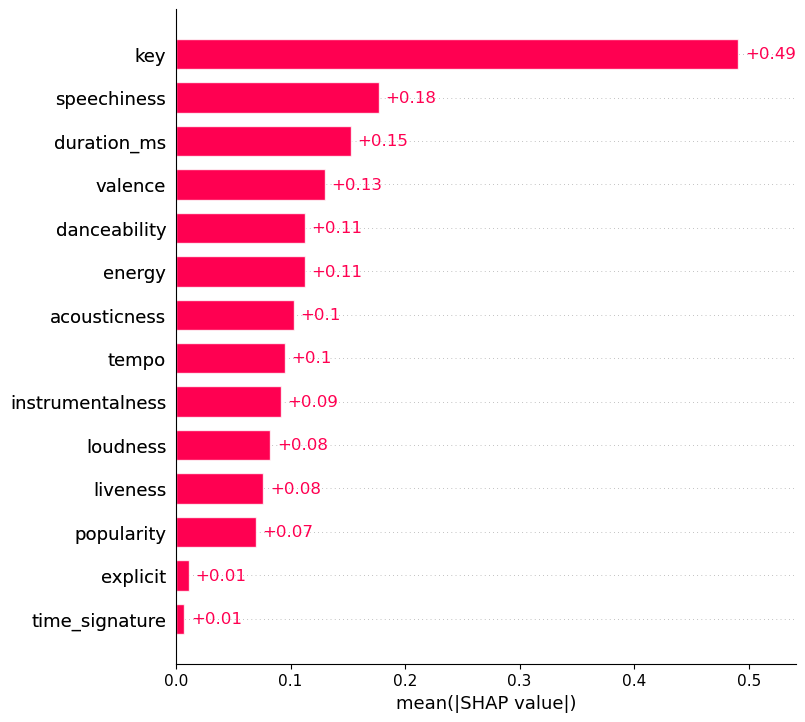

In [45]:
model = XGBClassifier()
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.plots.bar(shap_values, max_display=X_train.shape[1])



Zgodnie z uprzednią analizą to *key*, nawet pomimo traktowania jako kolumnę numeryczną, ma zdecydowanie największy wpływ na predykcje modelu. Spróbujmy pozbyć się kolumn wnoszących do niego najmniej.


In [48]:
X_train_dropped = X_train.drop(columns=['explicit', 'time_signature'])
X_test_dropped = X_test.drop(columns=['explicit', 'time_signature'])

evaluate_model(XGBClassifier(), X_train_dropped, X_test_dropped, y_train, y_test)


Accuracy: 0.691477053605862
Recall: 0.8821901849424785
Precision: 0.7170079299325364
F1: 0.7910681640114913

Predicted class balance:
1    81.459699
0    18.540301
dtype: float64

Original:
1.0    66.207096
0.0    33.792904
Name: mode, dtype: float64


Widzimy niewielką poprawę (+0.6% accuracy). Przy okazji przyjrzymy się dokładniej jak konkretne kolumny wpływają na model, rozpatrując posczególne klucze z *key* oddzielnie, już po skategoryzowaniu.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


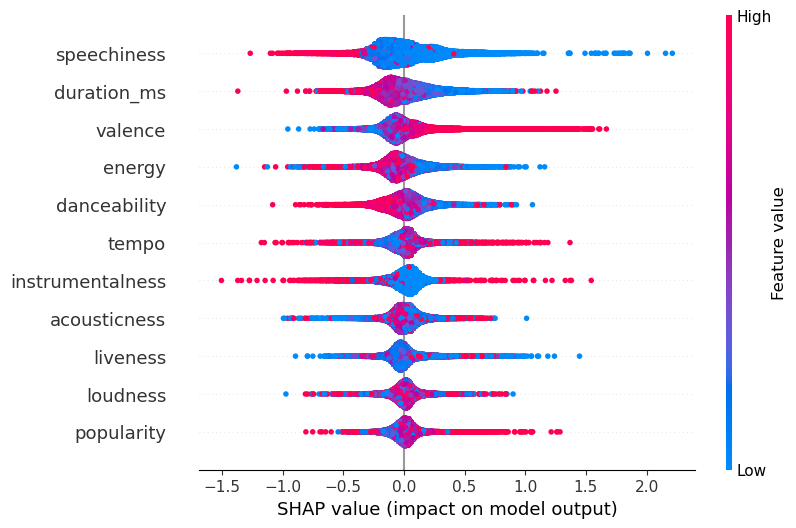

In [50]:
model = XGBClassifier()
model.fit(X_train_dropped.drop(columns=['key']), y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_train_dropped.drop(columns=['key']))

shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])


Z wykresu możemy odczytać kilka ciekawych informacji:
- utwory krótsze i zawierające mniej tekstu są częściej klasyfikowane jako durowe
- utwory szczęśliwe i radosne zwykle są durowe
- taneczność i instrumentalność cechuje raczej utwory mollowe


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


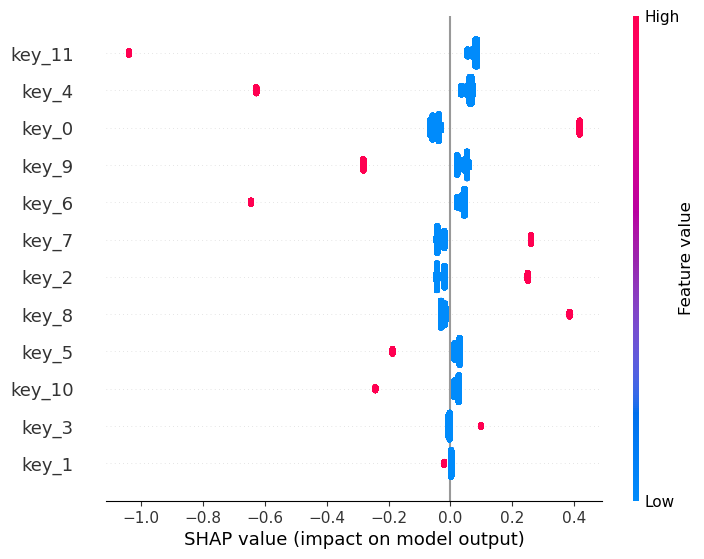

In [51]:
model = XGBClassifier()
model.fit(pd.get_dummies(X_train[['key']], columns=['key']), y_train)

explainer = shap.Explainer(model)
shap_values = explainer(pd.get_dummies(X_train[['key']], columns=['key']))

shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])


Po kluczach wyrażnie widać, że niektóre są bardziej mollowe, a inne durowe. W ramach testu sprawdzimy jak zadziałałby model oparty tylko na nich.


In [52]:
evaluate_model(XGBClassifier(),
               pd.get_dummies(X_train[['key']], columns=['key']),
               pd.get_dummies(X_test[['key']], columns=['key']),
               y_train,
               y_test)

Accuracy: 0.6751831854994215
Recall: 0.9592252803261978
Precision: 0.68075651095494
F1: 0.7963489089040682

Predicted class balance:
1    93.289626
0     6.710374
dtype: float64

Original:
1.0    66.207096
0.0    33.792904
Name: mode, dtype: float64


Widzimy, że skuteczność modelu opartego na samych kluczach jest jedynie odrobinę gorsza. Dużą wadą tego rozwiązania jest jednak to, że prawie wszystkie utwory są klasyfikowane jako durowe.


### Dodanie nowych atrybutów


Spróbujemy rozszerzyć model o nowe parametry, które, jak mamy nadzieję, poprawią skuteczność modelu.
Pierwsze o czym pomyśleliśmy, to dodanie informacji o gatunku gram przez autora utworu.


In [60]:
artists_df = pd.read_json('./data_v2/artists.jsonl', lines=True)


In [61]:
artists_df.head()

,id,name,genres
0,72578usTM6Cj5qWsi471Nc,Raghu Dixit,"[filmi, indian folk, indian rock, kannada pop]"
1,7b6Ui7JVaBDEfZB9k6nHL0,The Local Train,"[desi pop, hindi indie, indian indie, indian r..."
2,5wJ1H6ud777odtZl5gG507,Vishal Mishra,"[desi pop, modern bollywood]"
3,0n4a5imdLBN24fIrBWoqrv,Because,"[opm, pinoy hip hop, pinoy r&b, pinoy trap, ta..."
4,4gdMJYnopf2nEUcanAwstx,Anuv Jain,"[hindi indie, indian indie, indian singer-song..."


In [89]:
genres = ['folk', 'rock', 'pop', 'indie', 'hip hop', 'r&b', 'trap', 'latin', 'rap', 'classical']


for genre in genres:
    artists_df[genre] = artists_df.genres.apply(lambda x: 1 if genre in str(x) else 0)


In [90]:
artists_df.head()


,id,name,genres,pop,folk,rock,indie,hip hop,r&b,trap,latin,rap,classical
0,72578usTM6Cj5qWsi471Nc,Raghu Dixit,"[filmi, indian folk, indian rock, kannada pop]",1,1,1,0,0,0,0,0,0,0
1,7b6Ui7JVaBDEfZB9k6nHL0,The Local Train,"[desi pop, hindi indie, indian indie, indian r...",1,0,1,1,0,0,0,0,0,0
2,5wJ1H6ud777odtZl5gG507,Vishal Mishra,"[desi pop, modern bollywood]",1,0,0,0,0,0,0,0,0,0
3,0n4a5imdLBN24fIrBWoqrv,Because,"[opm, pinoy hip hop, pinoy r&b, pinoy trap, ta...",0,0,0,0,1,1,1,0,1,0
4,4gdMJYnopf2nEUcanAwstx,Anuv Jain,"[hindi indie, indian indie, indian singer-song...",0,0,0,1,0,0,0,0,0,0


In [91]:
artists_df = artists_df.drop(columns=['name', 'genres'])


In [92]:
tracks_df = pd.read_json('./data_v2/tracks.jsonl', lines=True)
tracks_df = tracks_df[~tracks_df['mode'].isna()]


In [98]:
merged_df = tracks_df.merge(artists_df, left_on='id_artist', right_on='id')

X_train_genre, X_test_genre, y_train, y_test = train_test_split(
    merged_df.drop(columns=['mode', 'name', 'id_x', 'id_y', 'id_artist', 'release_date']),
    merged_df['mode'],
    test_size=0.2,
    random_state=42
)


In [99]:
evaluate_model(XGBClassifier(), X_train_genre, X_test_genre, y_train, y_test)


Accuracy: 0.6921519475510991
Recall: 0.8895171813832101
Precision: 0.7162035956105534
F1: 0.7935070814201642

Predicted class balance:
1    82.587736
0    17.412264
dtype: float64

Original:
1.0    66.496336
0.0    33.503664
Name: mode, dtype: float64


Możemy zauważyć, że dodanie informacji o gatunku delikatnie poprawiło model (+0.7% accuracy).

Kolejną rzeczą jaką sprawdzimy jest dodanie informacji o porze roku w jakiej powstał utwór.

In [123]:
seasons = [
    ['spring', ['03', '04', '05']],
    ['summer', ['06', '07', '08']],
    ['autumn', ['09', '10', '11']],
    ['winter', ['12', '01', '02']]
]


for season in seasons:
    tracks_df[season[0]] = tracks_df.release_date.apply(lambda x: 1 if len(x) == 10 and x[5:7] in season[1] else 0)


In [125]:
X_train_season, X_test_season, y_train, y_test = train_test_split(
    tracks_df.drop(columns=['mode', 'id', 'name', 'id_artist', 'release_date']),
    tracks_df['mode'],
    test_size=0.2,
    random_state=42
)

evaluate_model(XGBClassifier(), X_train_season, X_test_season, y_train, y_test)


Accuracy: 0.686367142306209
Recall: 0.8817533129459735
Precision: 0.7126883239171374
F1: 0.788257501790015

Predicted class balance:
1    81.912842
0    18.087158
dtype: float64

Original:
1.0    66.207096
0.0    33.792904
Name: mode, dtype: float64


Wzrost skuteczności po dodaniu pory roku jest znikomy (+0.1%)


### Zebranie najlepszych rozwiązań i strojenie hiperparametrów

Połączymy teraz pomysły, które przyniosły najlepsze rezultaty:
1. kategoryzacja kolumny *key*
2. usuwanie niepotrzebnych atrybutów
3. dodanie nowych atrybutów



In [134]:
final_df = tracks_df.merge(artists_df, left_on='id_artist', right_on='id')
final_df = pd.get_dummies(final_df, columns=['key'])

X_train_final, X_test_final, y_train, y_test = train_test_split(
    merged_df.drop(columns=['mode', 'name', 'id_x', 'id_y', 'id_artist',
                            'release_date', 'explicit', 'time_signature']),
    merged_df['mode'],
    test_size=0.2,
    random_state=42
)

evaluate_model(XGBClassifier(), X_train_final, X_test_final, y_train, y_test)


Accuracy: 0.6923447743925955
Recall: 0.8863273887197333
Precision: 0.7174882629107981
F1: 0.7930206914445094

Predicted class balance:
1    82.144234
0    17.855766
dtype: float64

Original:
1.0    66.496336
0.0    33.503664
Name: mode, dtype: float64


Do tak przygotowanych danych możemy teraz dobrać najlepsze hiperparametry.

Po przeczytaniu dokumentacji zdecydowaliśmy się na dobranie następujących:

---
```
eta [default=0.3, alias: learning_rate]
```
Rozmiar kroku uczenia

---

```
max_depth [default=6]
```
Maksymalna głębokość drzewa.

---
```
n_estimators [default=100]
```
Liczba uruchomień algorytmu.

---

Dokładniejsze opisy znajdują się pod linkiem:

[Dokumentacja XGB](https://xgboost.readthedocs.io/en/stable/parameter.html)



In [146]:
best_result = 0.69

for eta in [0.05, 0.1, 0.15, 0.2]:
    for max_depth in [4, 5, 6, 7, 8]:
        for n_estimators in [10, 25, 50, 75, 100]:
            params = {
                'eta' : eta,
                'max_depth': max_depth,
                'n_estimators': n_estimators
            }

            model = XGBClassifier(**params)
            scores = cross_val_score(model, X_train_final, y_train, cv=5)

            if scores.mean() > best_result:
                best_result = scores.mean()
                
                print(best_result)
                print(params)
                print()


0.6913008511760589
{'eta': 0.05, 'max_depth': 4, 'n_estimators': 100}

0.6917828892321933
{'eta': 0.05, 'max_depth': 5, 'n_estimators': 75}

0.6925782819455806
{'eta': 0.05, 'max_depth': 5, 'n_estimators': 100}

0.6941209443237591
{'eta': 0.05, 'max_depth': 6, 'n_estimators': 75}

0.6949404624698755
{'eta': 0.05, 'max_depth': 6, 'n_estimators': 100}

0.6953984128573538
{'eta': 0.05, 'max_depth': 7, 'n_estimators': 75}

0.6957117210357476
{'eta': 0.05, 'max_depth': 7, 'n_estimators': 100}

0.695880517726848
{'eta': 0.05, 'max_depth': 8, 'n_estimators': 75}

0.6960733091288865
{'eta': 0.05, 'max_depth': 8, 'n_estimators': 100}

0.6968929144228634
{'eta': 0.1, 'max_depth': 7, 'n_estimators': 50}



In [153]:
best_params = {'eta': 0.1, 'max_depth': 7, 'n_estimators': 50}

evaluate_model(XGBClassifier(**best_params), X_train_final, X_test_final, y_train, y_test)

Accuracy: 0.7000578480524489
Recall: 0.922430042047267
Precision: 0.7117923472812709
F1: 0.8035364698452794

Predicted class balance:
1    86.174315
0    13.825685
dtype: float64

Original:
1.0    66.496336
0.0    33.503664
Name: mode, dtype: float64


Po dobraniu hiperparametrów metodą grid search, udało nam się spełnić założenia ustalone z klientem (accuracy 70%), więc ta wersja modelu może zostać uznana za finalną.


### Problem z niezbalansowaniem

Pomimo osiągnięcia postawionego celu, widzimy problem w tym, że nasz problem znacznie gorzej przewiduje utwory mollowe (ponad 80% predykcji to durr).

Naszą propozycją rozwiązania tego problemu jest ważenie klas na wejściu modelu za pomocą parametru *scale_pos_weight*.

In [154]:
best_params = {'eta': 0.1, 'max_depth': 7, 'n_estimators': 50, 'scale_pos_weight': 0.6}

evaluate_model(XGBClassifier(**best_params), X_train_final, X_test_final, y_train, y_test)

Accuracy: 0.6815464712688006
Recall: 0.764100333478324
Precision: 0.7587100489490354
F1: 0.7613956512316694

Predicted class balance:
1    66.968762
0    33.031238
dtype: float64

Original:
1.0    66.496336
0.0    33.503664
Name: mode, dtype: float64


Po tej zmianie widizmy znaczną poprawę i rozkład predykcji jest zgodny z rzeczywistością.
Niestety ucierpiała na tym skuteczność modelu, która spadła o prawie 2%. Wybór rozwiązania pozostawimy klientowi.